data from [A single-cell time-lapse of mouse prenatal development from gastrula to birth](https://www.nature.com/articles/s41586-024-07069-w), using the 32 first embryos, annotated as Tbx6p

In [1]:
import anndata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_FOLDER = "../data/"
adata = anndata.read_h5ad(
    f"{DATA_FOLDER}/somite/mesodermal_progenitors_Tbx6p_names_mapped.h5ad"
)

In [4]:
import scanpy as sc
import matplotlib.pyplot as plt


adata_mesoderm = adata.copy()

# UMAP: Preprocessing (if not already done)
sc.pp.normalize_total(adata_mesoderm, target_sum=1e4)
sc.pp.log1p(adata_mesoderm)
sc.pp.highly_variable_genes(adata_mesoderm, n_top_genes=2000)
adata_mesoderm = adata_mesoderm[:, adata_mesoderm.var.highly_variable]
sc.pp.scale(adata_mesoderm)
sc.tl.pca(adata_mesoderm, svd_solver="arpack")
sc.pp.neighbors(adata_mesoderm, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_mesoderm)

/home/maxine/miniconda3/envs/harmony_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


<Axes: >

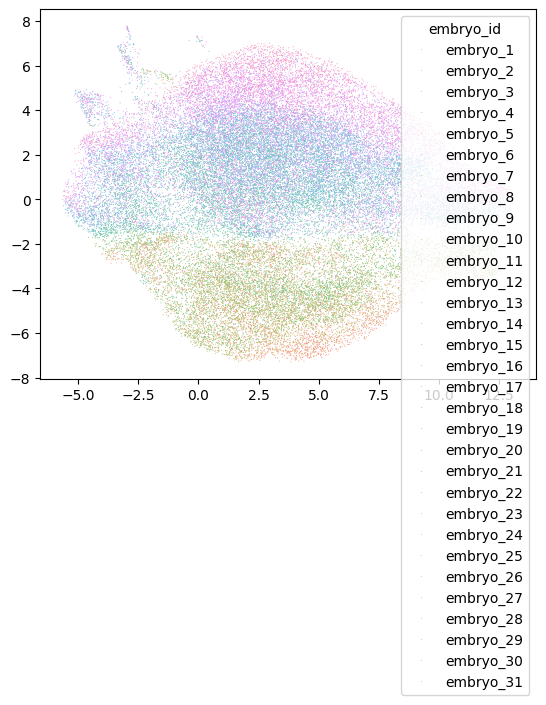

In [5]:
X = adata_mesoderm.obsm["X_umap"]
sns.scatterplot(x=X[:, 0], y=X[:, 1], s=0.4, hue=adata.obs["embryo_id"])

In [6]:
from harmony import harmonize

Z = harmonize(adata_mesoderm.obsm["X_pca"], adata_mesoderm.obs, batch_key="embryo_id")
adata_mesoderm.obsm["X_harmony"] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [7]:
Z.shape

(45358, 50)

In [27]:
# Compute neighbors using the Harmony-corrected embedding
sc.pp.neighbors(adata_mesoderm, use_rep="X_harmony")

# Run Leiden clustering
sc.tl.leiden(adata_mesoderm, resolution=0.3)

sc.tl.umap(adata_mesoderm)

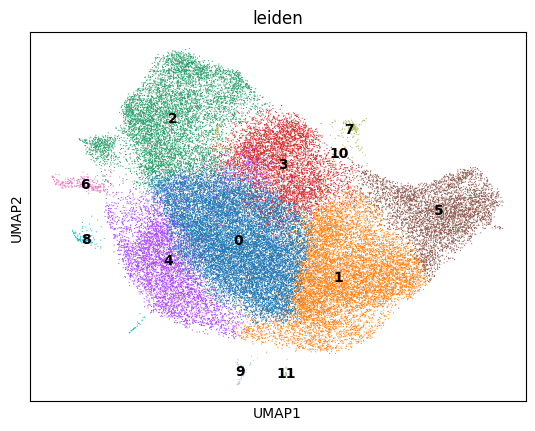

In [28]:
# Visualize the result
sc.pl.umap(adata_mesoderm, color="leiden", legend_loc="on data")

In [29]:
["0", "1", "2", "3", "4", "6", "14", "12", "10"]

['0', '1', '2', '3', '4', '6', '14', '12', '10']

In [42]:
adata_mesoderm.obs["leiden"].value_counts()

leiden
0     14924
1      9150
2      6842
3      4833
4      4800
5      4057
6       287
7       220
8       144
9        50
10       37
11       14
Name: count, dtype: int64

In [43]:
import numpy as np

from sklearn.decomposition import PCA

X = adata_mesoderm.obsm["X_umap"]
pca = PCA(n_components=2)

pca.fit(X)
print(pca.explained_variance_ratio_)

[0.69783586 0.3021641 ]


In [44]:
X = pca.transform(X)

In [51]:
adata_mesoderm

AnnData object with n_obs × n_vars = 45358 × 2000
    obs: 'cell_id', 'keep', 'day', 'embryo_id', 'experimental_batch', 'inferred_theta', 'leiden_label', 'is_TB', 'umap_density', 'cycling', 'posterior_anterior_axis', 'leiden'
    var: 'gene_id', 'gene_type', 'gene_short_name', 'chr', 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'umap_density_params', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_harmony', 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'log_norm', 'total'
    obsp: 'distances', 'connectivities'

In [45]:
sc.pp.neighbors(adata_mesoderm, n_neighbors=15, n_pcs=30)

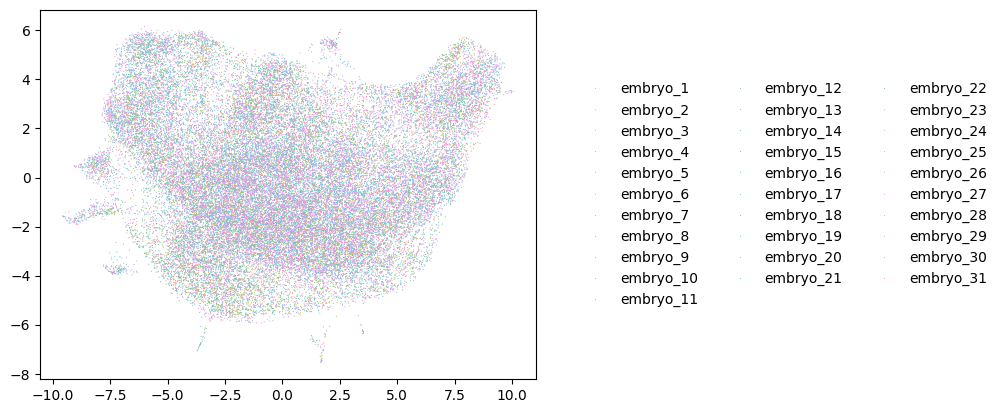

In [46]:
ax = sns.scatterplot(x=X[:, 0], y=X[:, 1], s=0.5, hue=adata.obs["embryo_id"])
sns.move_legend(
    ax,
    "center",
    bbox_to_anchor=(1.5, 0.5),
    ncol=3,
    title=None,
    frameon=False,
)

In [55]:
sc.tl.leiden(adata_mesoderm, resolution=0.7)

In [48]:
adata.layers["log_norm"] = np.log1p(np.log1p(adata.X))

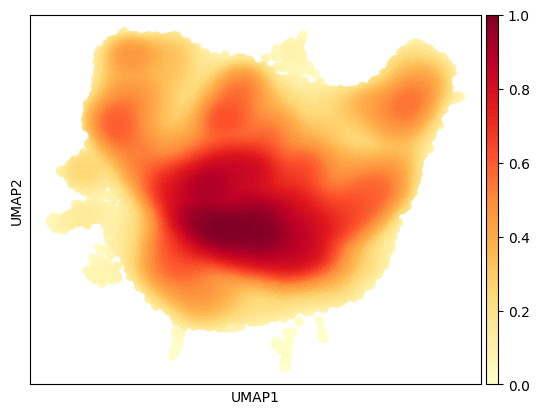

In [49]:
sc.tl.embedding_density(adata, basis="umap")
sc.pl.embedding_density(adata, basis="umap")

In [56]:
adata.obs["leiden"] = adata_mesoderm.obs["leiden"]

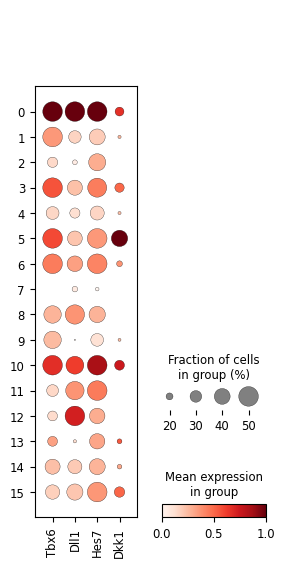

In [ ]:
# display number of cells expressing Tbx6 and mean number of counts per cluster
sc.pl.dotplot(
    adata,
    var_names=["Tbx6", "Dll1", "Hes7", "Dkk1"],
    groupby="leiden",
    standard_scale="var",
    dot_max=0.5,
    dot_min=0.1,
)

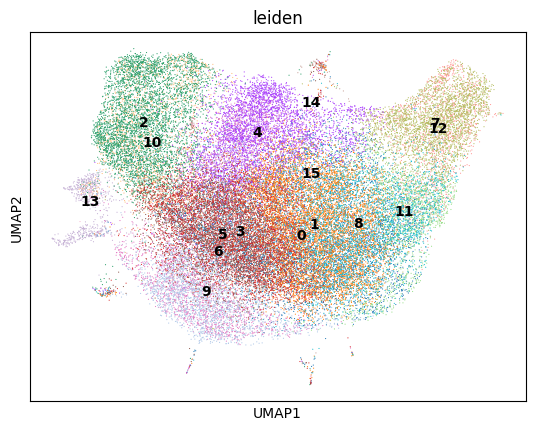

In [62]:
sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

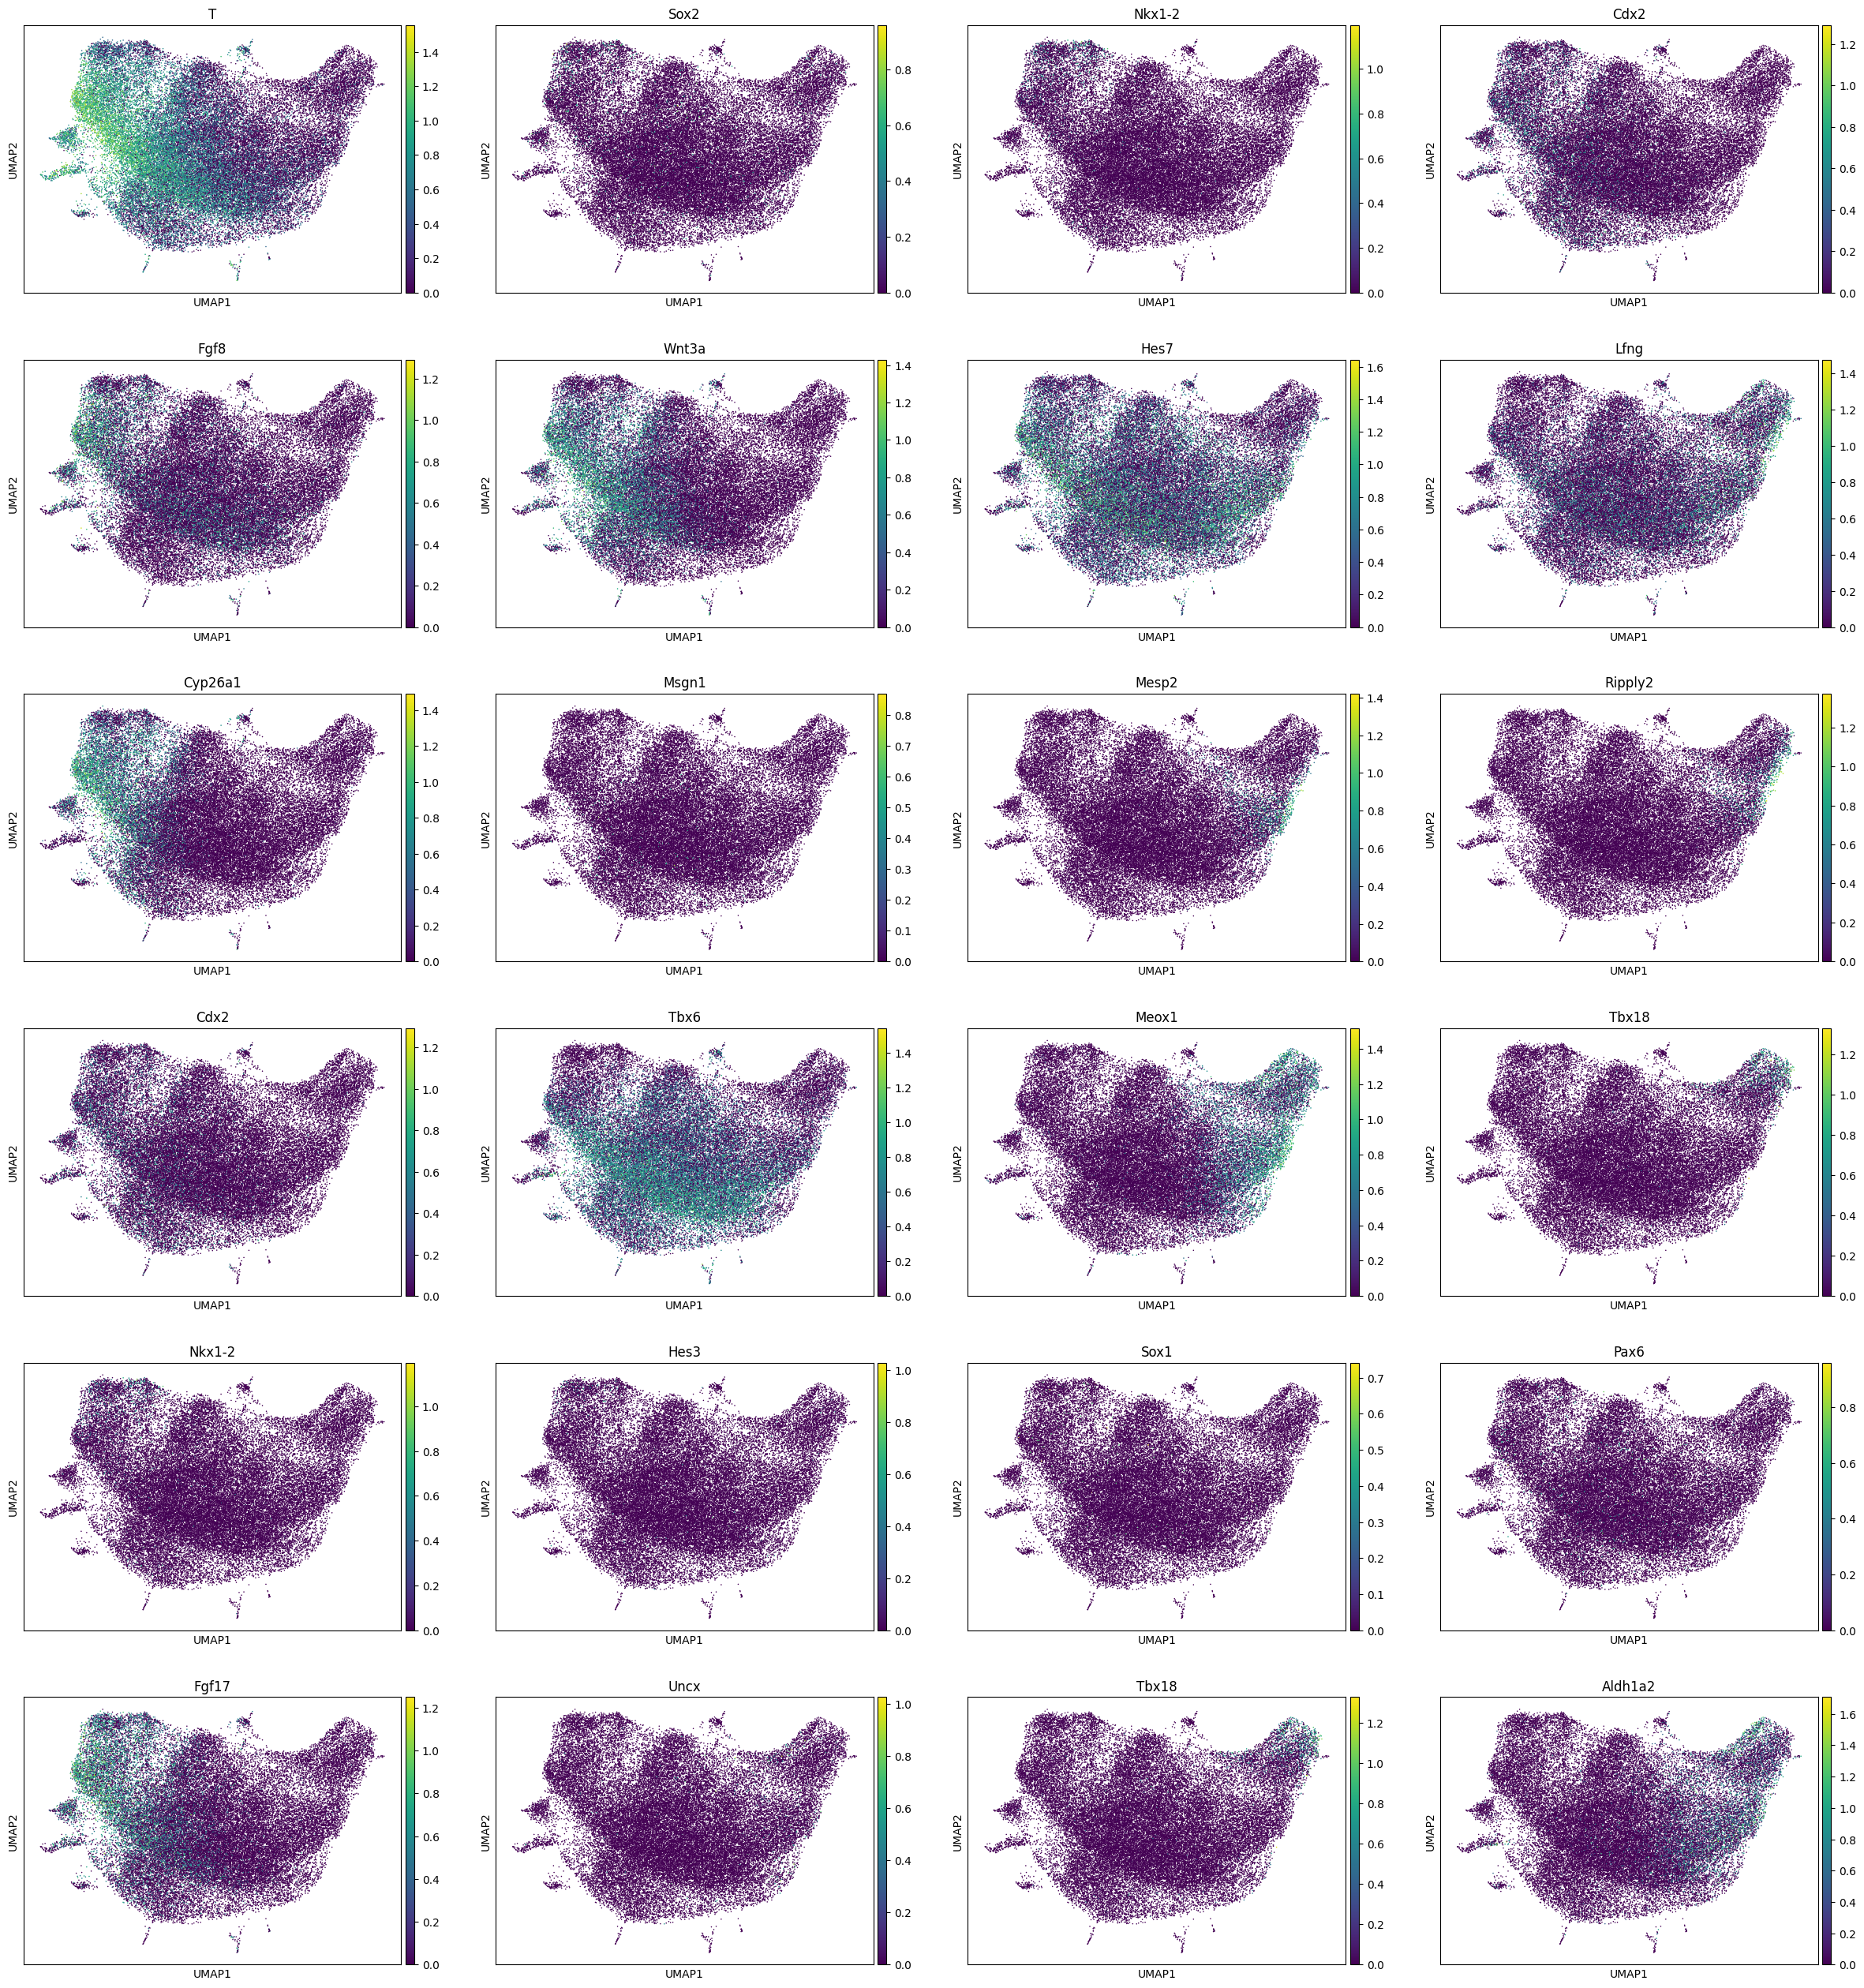

In [63]:
# Plot UMAP
adata.obsm["X_umap"] = X
sc.pl.umap(
    adata,
    layer="log_norm",
    color=["T", "Sox2", "Nkx1-2", "Cdx2", "Fgf8", "Wnt3a"]
    + [
        "Hes7",
        "Lfng",
        "Cyp26a1",
        "Msgn1",
        "Mesp2",
        "Ripply2",
        "Cdx2",
        "Tbx6",
        "Meox1",
        "Tbx18",
        "Nkx1-2",
        "Hes3",
        "Sox1",
        "Pax6",
        "Fgf17",
        "Uncx",
        "Tbx18",
        "Aldh1a2",
    ],
    cmap="viridis",
    # vmax=1,
    size=5,
    sort_order=False,
)

In [64]:
adata.obs["leiden_label"] = adata_mesoderm.obs["leiden"]

In [78]:
adata.obs["cycling"] = adata.obs["leiden_label"].isin(["0", "1", "3", "5", "6", "10"])

In [79]:
adata.obs["posterior_anterior_axis"] = adata.obsm["X_umap"][:, 0]

In [80]:
adata.obs["posterior_anterior_axis"]

run_4_P2-01A.CGTCTTCCTTAGGCCATAG-0          -5.489056
run_4_P2-01A.AAAGCTGATTCGTAATGCAG-0          7.330379
run_4_P2-01A.CGTTGATCTCTTGGTAATG-0           0.468246
run_4_P2-01A.AATACCGAATGGCGAACTCG-0         -3.276564
run_4_P2-01A.CGTAGGCTTTTAGGACCGG-0          -3.345171
                                               ...   
run_17_PD-12H_S384.GTCGTAACTAAGACGGCCA-2     5.356664
run_17_PD-12H_S384.GAGACTAGTTGCATATAAC-2     6.209332
run_17_PD-12H_S384.TAGCCAATTTTGCGGACCTA-2    6.320696
run_17_PD-12H_S384.TCGAAGGATTGGCTGATGA-2     2.158526
run_17_PD-12H_S384.ATGGTAACTTCCATTATCTA-2    0.328947
Name: posterior_anterior_axis, Length: 45358, dtype: float32

In [81]:
adata.obs["posterior_anterior_axis"].to_csv("posterior_anterior_axis.csv")

In [83]:
# adata.write_h5ad(
#     f"{DATA_FOLDER}/somite/mesodermal_progenitors_Tbx6p_names_mapped_2.h5ad",
#     compression="gzip",
# )